In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.lines import Line2D
import sklearn.decomposition as skd
import sklearn.mixture as skm
import utils
import GM
import tqdm
from scipy.stats import pearsonr
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import sklearn

In [3]:
gm = skm.GaussianMixture()
gm.weights_ = np.load("GM/weights.npy")
gm.means_ = np.load("GM/means.npy")
gm.covariances_ = np.load("GM/covariances.npy")
gm.precisions_cholesky_ = np.load("GM/precisions_cholesky.npy")

sample = gm.sample(10_000)

pca = skd.PCA(2)
gm_sample_pca = pca.fit_transform(sample[0])

In [4]:
W = np.load("GM/weights.npy")
M = np.load("GM/means.npy")
S = np.load("GM/covariances.npy")
 

gm2 = GM.GaussianMixture(W, M, S)

100%|██████████| 100000/100000 [04:59<00:00, 333.65it/s]


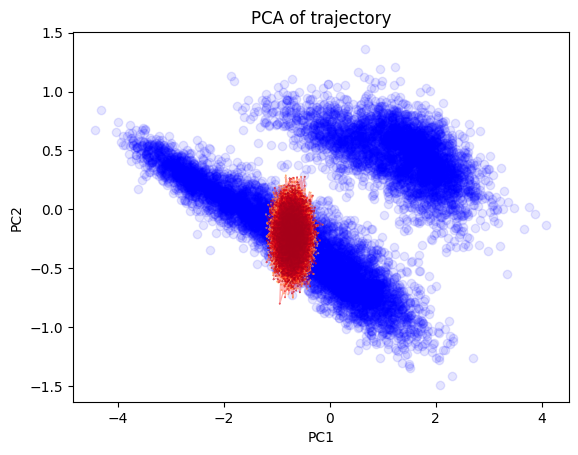

In [7]:
n_step=100_000
restart = True
X0 = np.load("latent_ini.npy") #+ np.random.normal(0,0.1,100)

# a = 3.22e-2 #0.01

lim = 0
while restart : 
    restart = False
    #X0 = gm.sample(1)[0].flatten()
    X0 = np.load("latent_ini.npy") + np.random.normal(0,0.1,100)
    traj = np.zeros((n_step+1, len(X0)))
    traj[0] = X0    
    for i in tqdm.tqdm(range(n_step)) : 

        traj[i+1] = gm2.Overdamped_Langevin(X0, a = 3.22e-2/2, T=1e-7) #std_noise=np.abs(np.random.normal(0, 1, 100))

        if np.linalg.norm(traj[i+1]) > 5: 
            restart=True#print("Trajectory exploded at step ", i+1, f" | norm: {np.linalg.norm(traj[i+1]):.2e}")
            lim += 1
            break
    if lim > 10:
        print("Too many explosions, stopping.")
        break

end_traj = -1
traj_2d = pca.transform(traj)
plt.title("PCA of trajectory")
plt.scatter(gm_sample_pca[:,0], gm_sample_pca[:,1], alpha = 0.1, c='b')
plt.scatter(traj_2d[:end_traj,0], traj_2d[:end_traj,1], c=np.arange(traj_2d[:end_traj,:].shape[0]), cmap="YlOrRd", s=0.1)
plt.plot(traj_2d[:end_traj,0], traj_2d[:end_traj,1], linewidth=1, c='r', alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Explained Variance :  [0.26828043 0.02946168]


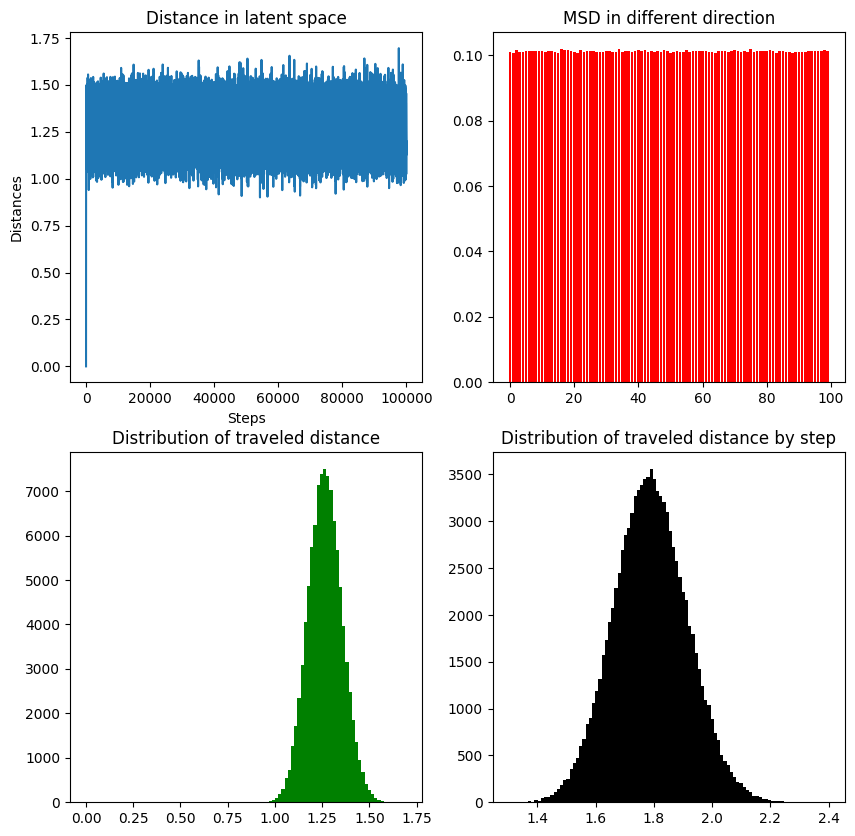

In [8]:
traj_2d = pca.transform(traj)
msd = utils.MSD(traj)
gm_affect = gm.predict(traj)

d = utils.dist_profile(traj)
d_traveled = utils.dist_traveled(traj)
d_step = utils.step_distances(traj)

end_traj = -1
print("Explained Variance : ", pca.explained_variance_ratio_)

plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
""" plt.title("PCA of trajectory")
plt.scatter(gm_sample_pca[:,0], gm_sample_pca[:,1], alpha = 0.1, c='b')
plt.scatter(traj_2d[:end_traj,0], traj_2d[:end_traj,1], c=np.arange(traj_2d[:end_traj,:].shape[0]), cmap="YlOrRd", s=0.1)
plt.plot(traj_2d[:end_traj,0], traj_2d[:end_traj,1], linewidth=1, c='r', alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2") """


plt.subplot(2,2,1)
plt.plot(range(len(d_traveled)), d_traveled)
plt.title('Distance in latent space')
plt.xlabel("Steps")
plt.ylabel("Distances")

#plt.subplot(2,2,3)
""" plt.hist(gm_affect, density=True, bins=len(gm.weights_))
plt.title("Gaussian affectation") """

plt.subplot(2,2,2)
plt.bar(range(len(d)), d, color='r')
plt.title("MSD in different direction")

plt.subplot(2,2,3)
plt.hist(d_traveled, bins=100, color='g')
plt.title("Distribution of traveled distance")


plt.subplot(2,2,4)
plt.hist(d_step, bins=100, color='k')
plt.title("Distribution of traveled distance by step")

plt.show()

Text(0.5, 1.0, 'Gaussian affectation')

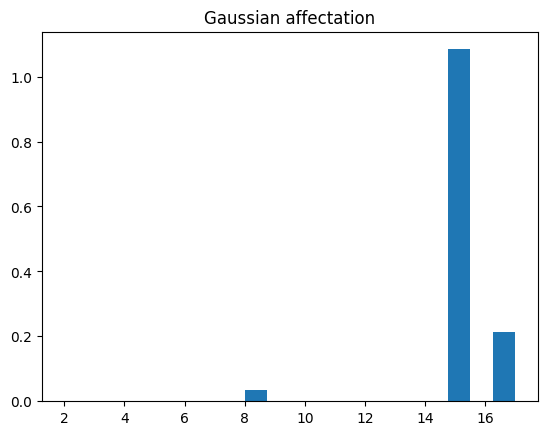

In [10]:
plt.hist(gm_affect, density=True, bins=len(gm.weights_))
plt.title("Gaussian affectation")

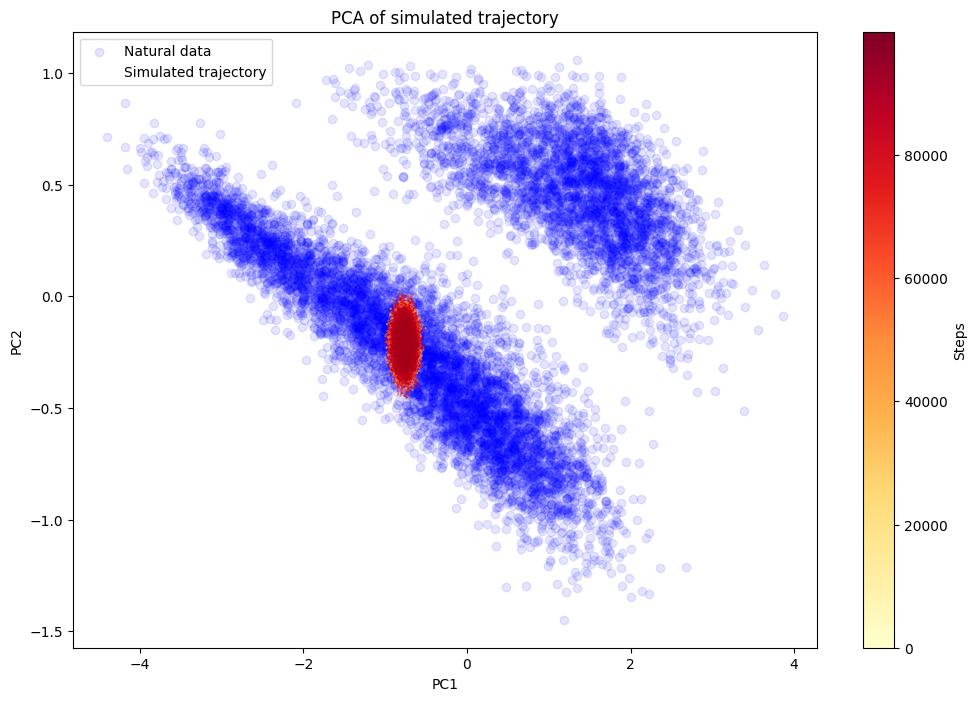

In [109]:
plt.figure(figsize=(12, 8))
plt.title("PCA of simulated trajectory")
plt.scatter(gm_sample_pca[:,0], gm_sample_pca[:,1], alpha = 0.1, c='b', label="Natural data")
plt.scatter(traj_2d[:end_traj,0], traj_2d[:end_traj,1], c=np.arange(traj_2d[:end_traj,:].shape[0]), cmap="YlOrRd", s=0.1, label="Simulated trajectory")
plt.plot(traj_2d[:end_traj,0], traj_2d[:end_traj,1], linewidth=1, c='r', alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.colorbar(label="Steps")
plt.show()

100%|██████████| 10001/10001 [00:35<00:00, 278.18it/s]


Pearson correlation : 0.0039


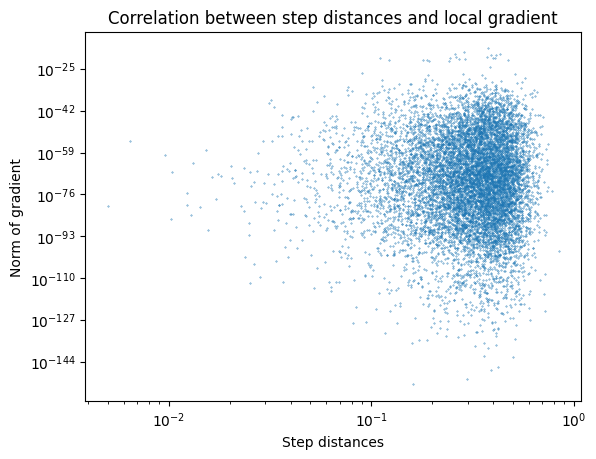

In [43]:
latent_distances = utils.step_distances(traj)
grad_vec = []
for i in tqdm.tqdm(range(traj.shape[0])) : 

    grad_vec.append(gm2.grad(traj[i]))
grad = np.linalg.norm(grad_vec, axis=1)

p = pearsonr(latent_distances, grad[:-1])

print(f"Pearson correlation : {p[0]:.4f}")

plt.scatter(latent_distances, grad[:-1], s=0.1)
plt.loglog()
plt.title("Correlation between step distances and local gradient")
plt.xlabel("Step distances")
plt.ylabel("Norm of gradient")
plt.show()

In [ ]:
n = 100
x = np.linspace(-2, 2, n)

z = np.zeros((n,n))
for i in range(n) : 
    for j in range(n) : 
        z[i,j] = gm4.transform(np.array([x[i], x[j]]))


x, y = np.meshgrid(x, x)



region = np.s_[5:50, 5:50]
x, y, z = x[region], y[region], z[region]

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

NameError: name 'lt' is not defined

In [38]:
gmm3 = sklearn.mixture.GaussianMixture(n_components=100)
gmm3.fit(gm_sample_pca)

gm4 = GM.GaussianMixture(gmm3.weights_, gmm3.means_, gmm3.covariances_)

In [39]:
n = 100
x = np.linspace(-1.5, 1.5, n)
y = np.linspace(-3, 3, n)

z = np.zeros((n,n))
grad = np.zeros((n,n))
for i in tqdm.tqdm(range(n)) : 
    for j in range(n) : 
        z[i,j] = gm4.transform(np.array([[y[i], x[j]]]))
        grad[i,j] = np.linalg.norm(gm4.grad(np.array([[y[i], x[j]]])))

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Gaussian :  -0.6299992482285606 -0.05289331802435656
Grad :  1.6446635170161138e-58 0.35100276487886134


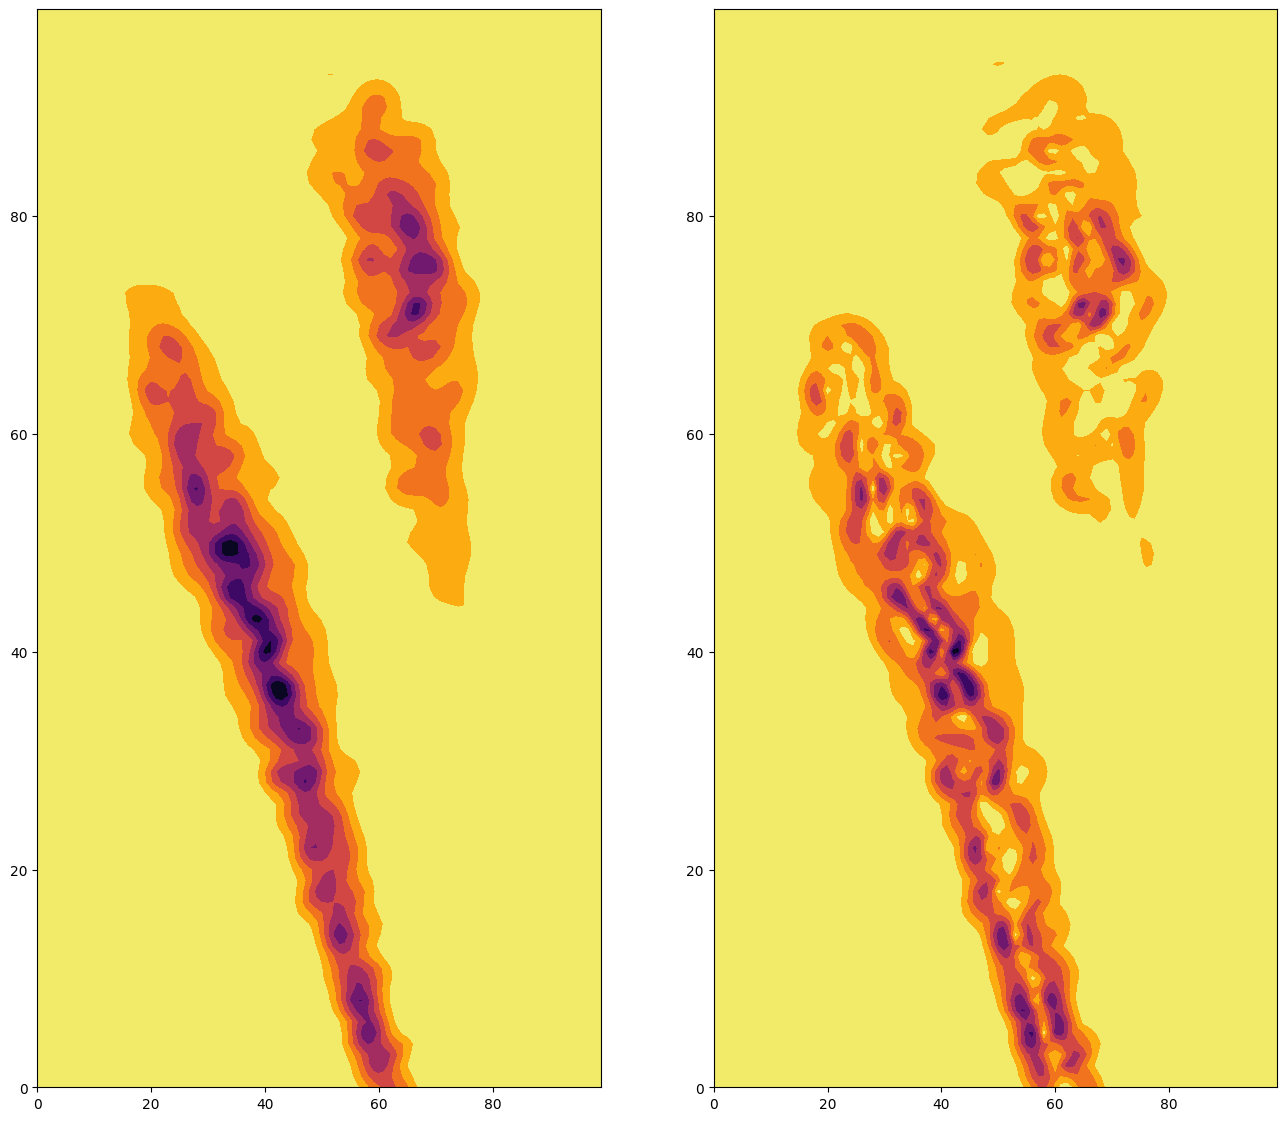

In [60]:
print("Gaussian : ", z.min(), z.mean())
print("Grad : ", grad.min(), grad.mean())


plt.figure(figsize=(16,14))
plt.subplot(1,2,1)
plt.contourf(z, cmap='inferno')


plt.subplot(1,2,2)
plt.contourf(-grad, cmap='inferno')
plt.show()

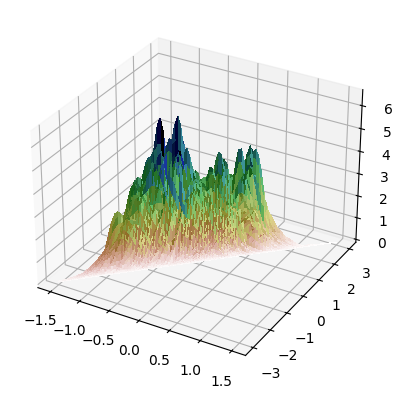

In [31]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, -z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

In [2]:
202 * 20

4040